In [1]:
import os
import gzip
import hashlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests
import matplotlib.pyplot as plt
import numpy as np
from torch import tensor, optim
from tqdm import trange
from torchvision import transforms
np.set_printoptions(suppress=True)

In [2]:
def imshow(img):
    plt.imshow(img)
    plt.show()
    
def plot(data):
    plt.plot(data)
    plt.show()

In [3]:
# data starts at offset 16
x_train_url = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
x_test_url = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'

# data starts at index 8
y_train_url = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
y_test_url = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'

In [8]:
def fetch(url):
    if not os.path.isdir('data'):
        os.mkdir('data')
    fp = md5 = 'data/' + hashlib.md5(url.encode()).hexdigest()
    if os.path.isfile(fp):
        with open(fp, 'rb') as f:
            dat = f.read()
    else:
        with open(fp, 'wb') as f:
            res = requests.get(url)
            res.raise_for_status()
            dat = res.content
            f.write(dat)
    assert b'503' not in dat, 'request failed'
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

In [9]:
x_train = fetch(x_train_url)[16:].reshape(-1, 28*28)
y_train = fetch(y_train_url)[8:]

x_test = fetch(x_test_url)[16:].reshape(-1, 28*28)
y_test = fetch(y_test_url)[8:]

3


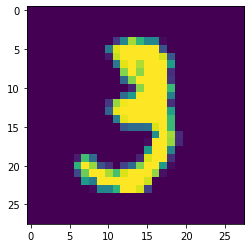

In [10]:
i = 10
img = x_train[i]
print(y_train[i])
plt.imshow(img.reshape(28, 28))
plt.show()

In [11]:
# setup
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(784, 128)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x

Loss: 0.14 Accuracy: 0.96: 100%|██████████| 500/500 [00:01<00:00, 333.34it/s]


finished training


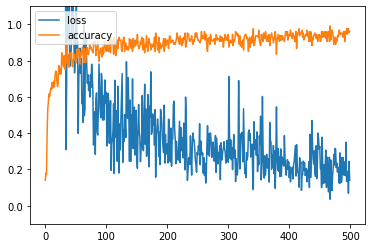

In [12]:
model = Net()

# train
epochs = 500
batch_size = 128
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
losses, accs = [], []
for i in (t := trange(epochs)):
    idx = np.random.randint(0, x_train.shape[0], size=(batch_size))
    x = tensor(x_train[idx]).float()
    y = tensor(y_train[idx]).long()
    optimizer.zero_grad()
    out = model(x)
    loss = loss_func(out, y)
    loss.backward()
    optimizer.step()

    acc = torch.div(torch.sum(torch.argmax(out, dim=1) == y), batch_size)

    losses.append(loss.detach().numpy())
    accs.append(acc.detach().numpy())
    t.set_description(f'Loss: {loss:.2f} Accuracy: {acc:.2f}')

print('finished training')

plt.ylim(-0.1, 1.1)
plt.plot(losses, label='loss')
plt.plot(accs, label='accuracy')
plt.legend(loc='upper left')
plt.show()

In [13]:
y_test_pred = torch.argmax(model(torch.tensor(x_test).float()), dim=1).numpy()
(y_test == y_test_pred).mean()

0.9325

In [14]:
l1 = np.zeros((784, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)
l1.dtype, l2.dtype, id(l1), id(l2)

(dtype('float32'), dtype('float32'), 5419624272, 5423720944)

In [15]:
model.l1

Linear(in_features=784, out_features=128, bias=True)

In [16]:
l1[:] = model.l1.weight.detach().numpy().T
l2[:] = model.l2.weight.detach().numpy().T
id(l1), id(l2)

(5419624272, 5423720944)

In [17]:
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)
    return x

In [18]:
y_test_preds_out = forward(x_test)
y_test_preds = np.argmax(y_test_preds_out, axis=1)
(y_test == y_test_preds).mean(), y_test_preds_out.shape

(0.9326, (10000, 10))

In [76]:
# train in numpy
# -y_test_preds[np.log(np.exp(y_test_preds[1]).sum())
i = 2
ret = -y_test_preds_out[range(y_test_preds_out.shape[0]), y_test] + np.log(np.exp(y_test_preds_out[i]).sum())
np.argmax(ret)

1014

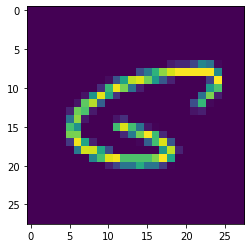

In [78]:
imshow(x_test[1014].reshape(28, 28))

In [21]:
set(list(np.sort(y_test_preds_out[:, y_test][0])))

{-25.51072,
 -13.137394,
 -8.669762,
 -5.923273,
 -4.597126,
 3.2125504,
 5.7200875,
 5.875095,
 24.69629,
 31.795465}

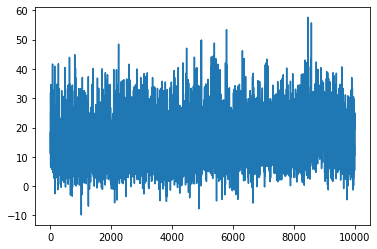

In [22]:
ret = y_test_preds_out[range(y_test_preds_out.shape[0]), y_test]
plot(ret)

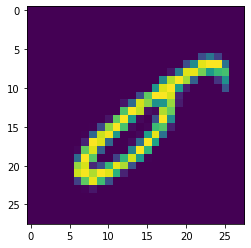

In [74]:
idx = np.argsort(ret)[3]
idx, ret[idx], y_test[idx]
imshow(x_test[idx].reshape(28, 28))